In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split


dataset = fetch_california_housing()

data = pd.DataFrame(dataset.data, columns=dataset.feature_names)
data['target'] = dataset.target

print(len(data))
data.head(10)

20640


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


In [4]:
print(dataset.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

This data contains 2 spacial features: `['Longitude', 'Latitude']`:

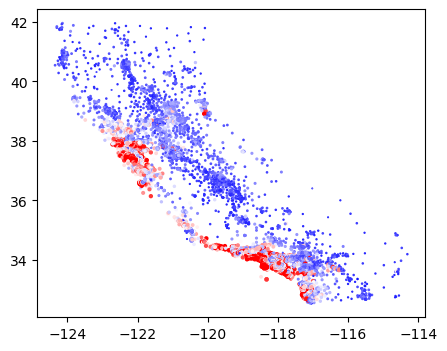

In [5]:
plt.figure(figsize=(5, 4), dpi=100)
plt.scatter(data.Longitude, data.Latitude, s=data.target, c=data.target, cmap='bwr');

(Compare this plot with the map of California: https://en.wikipedia.org/wiki/California)

A kNN model might be quite reasonable to use on this 2D subspace.

Let's first divide our data into train and test:

In [6]:
X, y = data.drop('target', axis=1), data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(15480, 8) (5160, 8) (15480,) (5160,)


 - Build a kNN regressor on the `Longitude` and `Latitude` features (**0.5 point**)
 - Build a random forest regressor on the rest of the features (**0.5 point**)
 - Build a stacking regressor (`sklearn.ensemble.StackingRegressor`) with 5-fold cross-val-predict using the two models above as the base models and a linear regression model as the final (aggregating) estimator. Don't forget to optimize hyper-parameters of your models. (**4 points**)
 - Compare the test MSE losses of the 3 models above, leave a comment (**1 point**)
 

Make sure to have a look at the documentation: 
https://scikit-learn.org/stable/modules/ensemble.html#stacking

You can make a pipeline (`sklearn.pipeline.make_pipeline`) with a `ColumnTransformer` (`sklearn.compose.make_column_transformer`) and a regression model (knn or random forest), where the `ColumnTransformer` will select the desired columns from the dataset (see the docs for the column transformer: https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html).

In [7]:
import numpy as np
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.metrics import mean_squared_error, make_scorer

In [8]:
knn_cols = ["Longitude", "Latitude"]
rf_cols = list(set(X.columns) - set(knn_cols))

In [9]:
pipe_knn = make_pipeline(make_column_transformer((StandardScaler(), knn_cols), remainder="drop"), KNeighborsRegressor())
pipe_rf = make_pipeline(make_column_transformer(('passthrough', rf_cols), remainder="drop"), RandomForestRegressor())

Let's find the best params for each model separately.

In [10]:
params_knn = {
    'kneighborsregressor__n_neighbors' : list(range(2, 25))
}

params_rf = {
    'randomforestregressor__max_depth': np.arange(2, 100, 10),
    'randomforestregressor__n_estimators' : np.arange(100, 350, 50)
}

scoring_metric = make_scorer(mean_squared_error)
grid_knn = GridSearchCV(pipe_knn, param_grid=params_knn, 
                        scoring=scoring_metric)

grid_rf = GridSearchCV(pipe_rf, param_grid=params_rf, 
                        scoring=scoring_metric, verbose=1, n_jobs=-1)

In [11]:
grid_knn.fit(X_train, y_train)
grid_knn.best_score_, grid_knn.best_params_

(0.33663679690230286, {'kneighborsregressor__n_neighbors': 24})

Text(0, 0.5, 'Test MSE score')

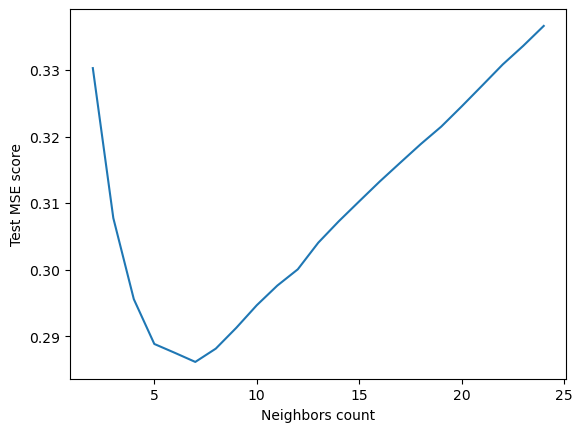

In [12]:
plt.plot(range(2, 25), grid_knn.cv_results_['mean_test_score'])
plt.xlabel("Neighbors count")
plt.ylabel("Test MSE score")

In [13]:
grid_rf.fit(X_train, y_train)
mean_squared_error(grid_rf.best_estimator_.predict(X_test), y_test), grid_rf.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/pokr_slav/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


(0.7478373128719144,
 {'randomforestregressor__max_depth': 2,
  'randomforestregressor__n_estimators': 100})

The next step is to find the result of applying the best models with the linear regression as a meta-model.

In [14]:
pipe_knn = make_pipeline(make_column_transformer((StandardScaler(), knn_cols), remainder="drop"), KNeighborsRegressor(n_neighbors=24))
pipe_rf = make_pipeline(make_column_transformer(('passthrough', rf_cols), remainder="drop"), RandomForestRegressor())

In [15]:
stacking = StackingRegressor(estimators=[("knn", pipe_knn), ("random_forest", pipe_rf)],
                  final_estimator=LinearRegression(), verbose=1, n_jobs=-1
    )

In [16]:
stacking.fit(X_train, y_train);
mean_squared_error(stacking.predict(X_test), y_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.1s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished


0.25318374726765464

Let's hypertune parameters deep into the stacking process.

In [17]:
params = {"knn__kneighborsregressor__n_neighbors" : list(range(2, 30, 8)), 
          "random_forest__randomforestregressor__max_depth" : np.arange(2, 20, 10)
}

grid = GridSearchCV(stacking, param_grid=params, verbose=1, n_jobs=-1)

In [18]:
grid.fit(X_train, y_train)
mean_squared_error(grid.best_estimator_.predict(X_test), y_test)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBa

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.9s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


0.23625572151183846

In [19]:
grid.best_params_

{'knn__kneighborsregressor__n_neighbors': 10,
 'random_forest__randomforestregressor__max_depth': 12}

As we can see, stacking model performs better than each model separately. It can be explained by the bias-variance tradeoff theorem.